Code associated with paper "Theta oscillations as a substrate for medial prefrontal-hippocampal assembly interactions"

Michele Nardin, Karola Kaefer, Federico Stella, Jozsef Csicsvari

In this notebook, we will take the matrix of functional correlations across CA1-PFC neurons and cluster them. 
This is effectively a clustering of a bipartite graph.

In [1]:
import numpy as np
import networkx as nx
import scipy.stats as stat
import matplotlib.pyplot as plt

In [116]:
# binarize FnC matrix, i.e. compute adjacency matrix A:
def binarize_mat(W,thr=3):
    
    # everything above threshold will be set to a positive value, everything else to zero
    A = np.array(W)
    
    A[A<=thr] = 0
    A[A>thr] = 1
    
    # find cells that are (functionally) connected to at least another cell in the other area
    c1s = np.where(np.sum(A,1)>0)[0]
    cps = np.where(np.sum(A,0)>0)[0]
    
    # exclude cells that are not (functionally) connected to anything
    A = A[np.sum(A,1)>0][:,np.sum(A,0)>0]
    
    # add small epsilon for numerical stability
    A+=1e-06 
    
    return A, c1s, cps

# normalized cut score
def Ncut(W,A,Ac,B,Bc):
    cut = np.sum(W[A][:,Bc]) + np.sum(W[Ac][:,B])
    WAB = np.sum(W[A]) + np.sum(W[:,B])
    WAcBc = np.sum(W[Ac]) + np.sum(W[:,Bc])
    return cut / WAB + cut / WAcBc

# clustering based on the second eigenvector of the laplacian
def recurrent_spectral_clustering(A, # adjacency matrix
                                  maxcl=6 # maximum number of cells per area in a cluster
                                 ):
    # list to save clusters here
    clusts = []
    
    # indexes along x and y axis
    indsx = np.arange(len(A))
    indsy = np.arange(len(A.T))

    A_split = A.copy() # we will recursively split the adjacency matrix A
    
    while len(A_split)>2 and len(A_split.T)>2: # do not split further when you get to the last 2CA1 / 2PFC
        
        # compute normalized Laplacian (NL) matrix of bipartite graph
        Dx = np.diagflat(np.sum(A_split,1)**(-1/2))
        Dy = np.diagflat(np.sum(A_split,0)**(-1/2))
        NL = Dx@A_split@Dy
        
        # SVD 
        V,s,U = np.linalg.svd(NL)
        
        # project along the eigenvectors with second largest eigenvalue
        x = Dx@V.T[1]
        y = Dy@U[1]
        
        # sort in descending order
        xs = np.argsort(-x)
        ys = np.argsort(-y)

        # reshuffle labels accordingly
        indsx = indsx[xs]
        indsy = indsy[ys]

        # find best split using the normalized cut score
        scores = np.zeros([min(maxcl,len(xs))-1,min(maxcl,len(ys))-1])
        for ixs in range(1,min(maxcl,len(xs))):
            for iys in range(1,min(maxcl,len(ys))):
                scores[ixs-1,iys-1] = Ncut(A_split,xs[:ixs],xs[ixs:],ys[:iys],ys[iys:])
        
        # find place with minimum score - split there!
        armi = np.where(scores == np.min(scores))
        bcA = 1+armi[0][0] # where to stop CA1
        bcB = 1+armi[1][0] # where to stop PFC
        
        # add clusters to list
        clusts.append([indsx[:bcA],indsy[:bcB]])
        
        # update labels for remaining cells
        indsx = indsx[bcA:]
        indsy = indsy[bcB:]
        
        # update adjacency matrix (i.e. remaining cells after the split)
        A_split = A_split[xs[bcA:]][:,ys[bcB:]]
        
    # add last cluster with the leftover few cells
    clusts.append([indsx,indsy])
    
    return clusts

In [85]:
# script for plotting nice bipartite graphs and clusters
def draw_bipart(W,clust=[]):
    G = nx.Graph()

    G.add_nodes_from(np.arange(len(W)))
    G.add_nodes_from(np.arange(len(W),len(W)+len(W.T)))
    for i in range(len(W)):
        for j in range(len(W.T)):
            if W[i,j]>1:
                G.add_edge(i,len(W)+j)
        cols=['tab:blue']*len(W) + ['tab:red']*len(W.T)
    
    lc = len(clust)
    pos = nx.bipartite_layout(G,np.arange(len(W)))
    
    if lc>0:
        nc = sum([max(len(c[0]),len(c[1])) for c in clust])
        
        p=np.zeros(nc)
        pa = np.zeros(nc)
        pb = np.zeros(nc)
        m=0
        for ic,c in enumerate(clust):
            la = len(c[0])
            lb = len(c[1])
            pa[m:m+la] = 1
            pb[m:m+lb] = 1
            m = m+max(la,lb)
            
            if ic<len(clust)-1:
                p[m]=1
                plt.axhline(y = m+np.sum(p),color='k',ls='dotted')
            
        posy = np.arange(1,nc+1) + np.cumsum(p)
        pa = pa*posy
        pb = pb*posy
        pa = pa[pa>0]
        pb = pb[pb>0]

        # update y coordiantes
        for i in range(len(W)):
            pos[i][1] = pa[i]
        for j in range(len(W.T)):
            pos[len(W)+j][1] = pb[j]

    nx.draw_networkx(G=G,
                     pos=pos,
                     with_labels=False,
                     node_color=cols)
    
    plt.axis('off')

In [144]:
# load previously computed functional correlations
func_corr_delay = np.load('func_corr.npy')
# as in the paper, consider theta cycle delay (125ms)
W = np.nanmax(np.flip(func_corr_delay,0)[40:46],0)

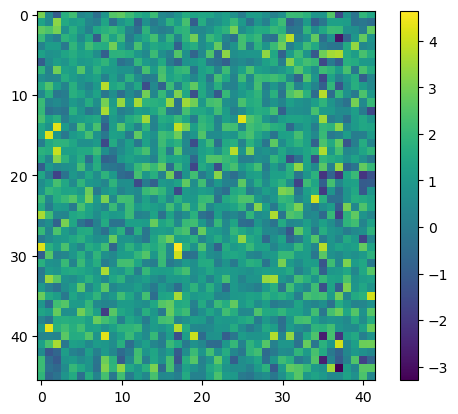

In [145]:
plt.imshow(W)
plt.colorbar()

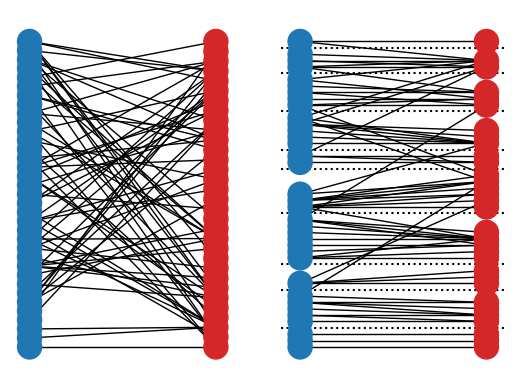

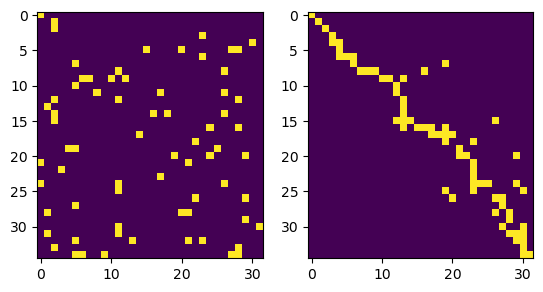

In [149]:
# bipartite cluster
Wf, c1s_sta, cps_sta = fix_W(W,3)        
cs_sta = rec_sp_imp(Wf,8)

# plot the results of the clustering
plt.subplot(1,2,1)
draw_bipart(Wf)
plt.subplot(1,2,2)
cA = np.concatenate([c[0] for c in cs_sta])
cB = np.concatenate([c[1] for c in cs_sta])
draw_bipart(Wf[cA][:,cB],cs_sta)

plt.show()

plt.subplot(1,2,1)
plt.imshow(Wf)
plt.subplot(1,2,2)
plt.imshow(Wf[cA][:,cB])
plt.show()
